In [72]:
#requirements
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor


In [73]:

# # Load asthma dataset
# asthma_df = pd.read_excel('./asthma/ALL VARIABLES.xlsx', sheet_name='Sheet1', engine='openpyxl')
# asthma_df.columns = asthma_df.columns.str.strip().str.replace(' ', '_')
# asthma_df = asthma_df.dropna(subset=['ASTHMA'])

# # Fill missing age groups with medians
# age_cols = ['1-20_YRS', '21-40_YRS', '41-60_YRS', '61-80_YRS', '81-100_YRS']
# asthma_df[age_cols] = asthma_df[age_cols].fillna(asthma_df[age_cols].median())


In [76]:
stations_string = """,STATION 1 EKSUTH ADO,Unnamed: 1,PM2.5,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,STATION 2 FMC IDO,Unnamed: 9,PM2.5.1,Unnamed: 11,SO2,Unnamed: 13,Unnamed: 14,STATION 3 GENERAL HOSPITAL IKERE,Unnamed: 16,PM 2.5,Unnamed: 18,SO2.1,Unnamed: 20,STATION4,MOBA LGA,Unnamed: 23,PM 2.5.1,Unnamed: 25,SO2.2,Unnamed: 27,STATION5,UNIMEDTH ONDO,Unnamed: 30,PM2.5.2,Unnamed: 32,SO2.3,Unnamed: 34,Unnamed: 35,STATION 6,FMC OWO,Unnamed: 38,PM2.5.3,Unnamed: 40,SO2.4,Unnamed: 42,Unnamed: 43,STATION 7,IDANRE,PM 2.5.2,Unnamed: 47,SO2.5,Unnamed: 49,STATION8,IJU,Unnamed: 52,PM2.5.4,Unnamed: 54,SO2.6,Unnamed: 56,Unnamed: 57,STATION 9,ILE OLUJI,Unnamed: 60,PM2.5.5,Unnamed: 62,SO2.7,Unnamed: 64,Unnamed: 65,STATION 10,ORE GEN HOSP,Unnamed: 68,PM2.5.6,Unnamed: 70,SO2.8,Unnamed: 72,Unnamed: 73,STATION11,OAUTHC IFE,Unnamed: 76,PM2.5.7,SO2.9,Unnamed: 79,Unnamed: 80,Unnamed: 81,STATION 12 SDA,Unnamed: 83,PM 2.5.3,Unnamed: 85,SO2.10,Unnamed: 87"""
stations = []
for i in stations_string.split(','):
    if 'STATION' in i:
        stations.append(i)


# %%
# print(stations)

In [80]:
import os
import pandas as pd

all_station_data = []

for station in stations:
    filename = f"./data/{station.replace(' ', '_')}.csv"
    if os.path.exists(filename):
        print(f"Loading {filename}")
        df = pd.read_csv(filename)
        df.columns = ['DATE', 'TOTAL', 'TIME', 'PM2.5', 'SO2_TIME', 'SO2_wrong', 'Location']
        df['Location'] = station.strip().upper()
        df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
        df = df.dropna(subset=['DATE'])
        df['YEAR'] = df['DATE'].dt.year
        all_station_data.append(df)
    else:
        print(f"Missing: {filename}")

# Combine all stations
full_station_df = pd.concat(all_station_data, ignore_index=True)
full_station_df['YEAR'] = full_station_df['YEAR'].astype(int)
full_station_df['Location'] = full_station_df['Location'].str.strip().str.upper()

# 📘 Load and melt SO₂ reference table
so2_df = pd.read_excel('./asthma/SO2.xlsx', sheet_name='Sheet2', engine='openpyxl')
so2_df = pd.melt(so2_df, id_vars='Location', var_name='YEAR', value_name='SO2')
so2_df['YEAR'] = so2_df['YEAR'].astype(int)
so2_df['Location'] = so2_df['Location'].str.strip().str.upper()

# # 🔁 Merge new SO₂ values
# merged_df = pd.merge(
#     full_station_df.drop(columns=['SO2_wrong'], errors='ignore'),  # Drop wrong column if it exists
#     so2_df,
#     on=['Location', 'YEAR'],
#     how='left'
# )

# # ✅ Check result
# print(merged_df[['Location', 'YEAR', 'SO2']].dropna().head())
# print(f"SO2 NaNs remaining: {merged_df['SO2'].isna().sum()}")


Loading ./data/STATION_1_EKSUTH_ADO.csv
Loading ./data/STATION_2_FMC_IDO.csv
Loading ./data/STATION_3_GENERAL_HOSPITAL_IKERE.csv
Loading ./data/STATION4.csv
Loading ./data/STATION5.csv
Loading ./data/STATION_6.csv
Loading ./data/STATION_7.csv
Loading ./data/STATION8.csv
Loading ./data/STATION_9.csv
Loading ./data/STATION_10.csv
Loading ./data/STATION11.csv
Loading ./data/STATION_12_SDA.csv


In [81]:
# merged_df.columns = ['DATE', 'ASTHMA', 'TIME', 'PM2.5', 'SO2_TIME', 'SO2', 'Location', 'YEAR']
# Load and clean SO2 reference data
# merged_df.to_csv('./formatted/combined_station_data.csv', index=False)
full_station_df

,DATE,TOTAL,TIME,PM2.5,SO2_TIME,SO2_wrong,Location,YEAR
0,2018-01-01,36,2018-01-01 00:00:00,1.620000e-07,2018-01-01 00:00:00,1.192694e-09,STATION 1 EKSUTH ADO,2018
1,2018-02-01,36,2018-02-01 00:00:00,8.260000e-08,2018-02-01 00:00:00,5.775183e-10,STATION 1 EKSUTH ADO,2018
2,2018-03-01,30,2018-03-01 00:00:00,5.150000e-08,2018-03-01 00:00:00,4.201633e-10,STATION 1 EKSUTH ADO,2018
3,2018-04-01,19,2018-04-01 00:00:00,5.450000e-08,2018-04-01 00:00:00,3.107343e-10,STATION 1 EKSUTH ADO,2018
4,2018-05-01,2,2018-05-01 00:00:00,2.790000e-08,2018-05-01 00:00:00,3.164205e-10,STATION 1 EKSUTH ADO,2018
...,...,...,...,...,...,...,...,...
715,2022-08-01,17,2022-08-01 00:00:00,1.117045e-08,2022-08-01 00:00:00,1.766659e-10,STATION 12 SDA,2022
716,2022-09-01,16,2022-09-01 00:00:00,1.200672e-08,2022-09-01 00:00:00,2.341484e-10,STATION 12 SDA,2022
717,2022-10-01,24,2022-10-01 00:00:00,4.117459e-08,2022-10-01 00:00:00,4.913324e-10,STATION 12 SDA,2022
718,2022-11-01,21,2022-11-01 00:00:00,5.374344e-08,2022-11-01 00:00:00,7.418670e-10,STATION 12 SDA,2022


In [ ]:
full_station_df = pd.read_csv('./formatted/combined_station_data.csv')
full_station_df['DATE'] = pd.to_datetime(full_station_df['DATE'], errors='coerce')

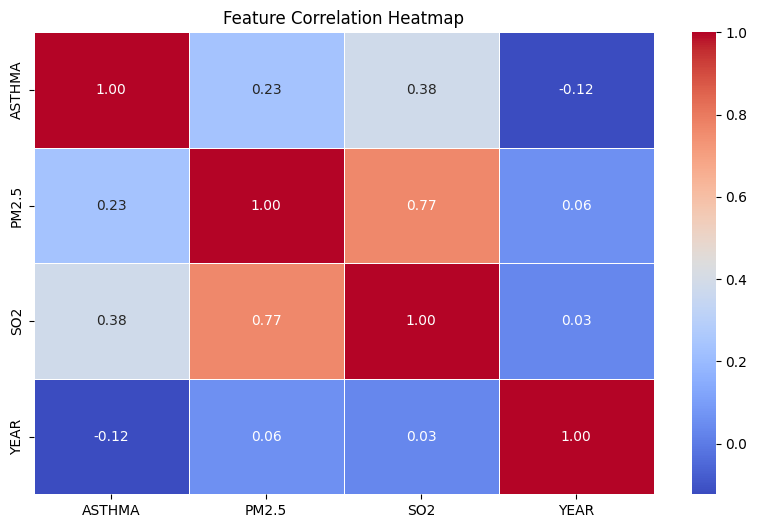

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = full_station_df.corr(numeric_only=True)

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


In [36]:
# %% [Setup]


# Set thread environment limit to avoid memory issues
os.environ["OPENBLAS_NUM_THREADS"] = "1"

# %% [Ensure output directory exists]
os.makedirs("asthma_models", exist_ok=True)

# %% [Prepare the Data]
# Assuming full_station_df is already loaded and cleaned
features = ['PM2.5', 'SO2']
target = 'ASTHMA'

df = full_station_df.dropna(subset=features + [target])
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)












In [26]:
# %% [Train and Save Models]

results = []

📈 Linear Regression Evaluation
   R² Score: 0.2202
   RMSE    : 11.29


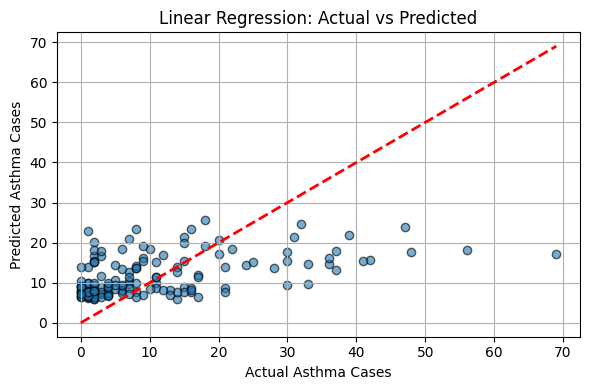

In [27]:

# --- Linear Regression ---
lr = LinearRegression()
lr.fit(X_train, y_train)
joblib.dump(lr, 'asthma_models/linear_regression.pkl')
results.append(("Linear Regression", lr))

# Predict using trained model
y_pred_lr = lr.predict(X_test)

# Calculate metrics
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("📈 Linear Regression Evaluation")
print(f"   R² Score: {r2_lr:.4f}")
print(f"   RMSE    : {rmse_lr:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_lr, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Asthma Cases")
plt.ylabel("Predicted Asthma Cases")
plt.title("Linear Regression: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.savefig("asthma_models/LinearRegression_plot.png")
plt.show()

🌲 Random Forest Evaluation
   R² Score: 0.0522
   RMSE    : 12.45


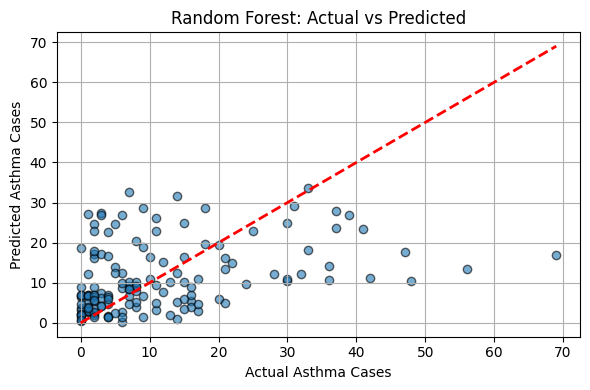

In [28]:

# --- Random Forest ---
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
joblib.dump(rf, 'asthma_models/random_forest.pkl')
results.append(("Random Forest", rf))
# Predict using trained model
y_pred_rf = rf.predict(X_test)

# Calculate metrics
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("🌲 Random Forest Evaluation")
print(f"   R² Score: {r2_rf:.4f}")
print(f"   RMSE    : {rmse_rf:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_rf, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Asthma Cases")
plt.ylabel("Predicted Asthma Cases")
plt.title("Random Forest: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.savefig("asthma_models/RandomForest_plot.png")
plt.show()

📦 XGBoost Evaluation
   R² Score: 0.0649
   RMSE    : 12.36


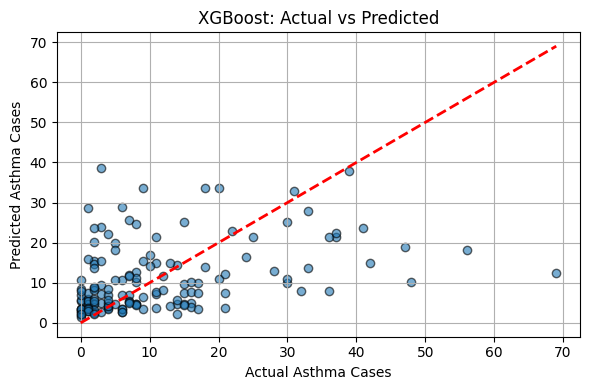

In [29]:
# --- XGBoost ---
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
joblib.dump(xgb, 'asthma_models/xgboost.pkl')
results.append(("XGBoost", xgb))
# Predict
y_pred_xgb = xgb.predict(X_test)

# Metrics
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print("📦 XGBoost Evaluation")
print(f"   R² Score: {r2_xgb:.4f}")
print(f"   RMSE    : {rmse_xgb:.2f}")

# Visualization
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_xgb, alpha=0.6, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Asthma Cases")
plt.ylabel("Predicted Asthma Cases")
plt.title("XGBoost: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.savefig("asthma_models/XGBoost_plot.png")
plt.show()

🧠 Neural Network Performance
   R² Score: -0.0122
   RMSE    : 12.86


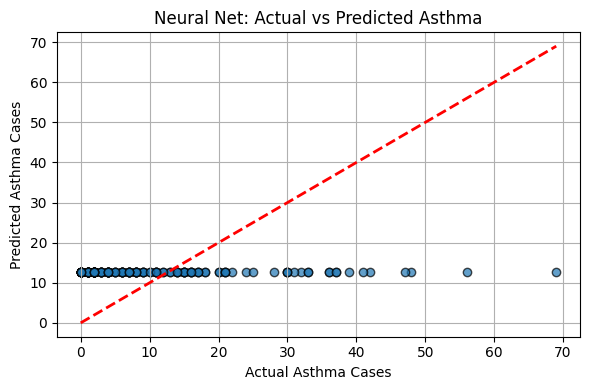

In [31]:
# --- Neural Network ---
mlp = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)
joblib.dump(mlp, 'asthma_models/neural_net.pkl')
results.append(("Neural Net", mlp))

# --- Predict & Evaluate ---
y_pred_mlp = mlp.predict(X_test)
r2 = r2_score(y_test, y_pred_mlp)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_mlp))

print("🧠 Neural Network Performance")
print(f"   R² Score: {r2:.4f}")
print(f"   RMSE    : {rmse:.2f}")

# --- Visualization ---
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_mlp, alpha=0.7, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Asthma Cases")
plt.ylabel("Predicted Asthma Cases")
plt.title("Neural Net: Actual vs Predicted Asthma")
plt.grid(True)
plt.tight_layout()
plt.savefig("asthma_models/neural_net_plot.png")
plt.show()

🔁 SVR Evaluation
   R² Score: -0.1057
   RMSE    : 13.45


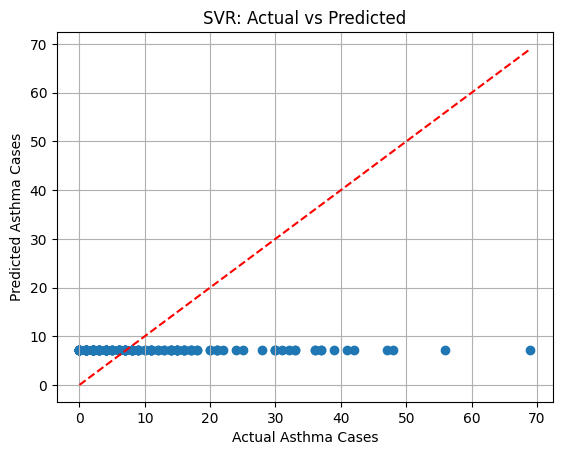

In [37]:
svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

r2_svr = r2_score(y_test, y_pred_svr)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))

print("🔁 SVR Evaluation")
print(f"   R² Score: {r2_svr:.4f}")
print(f"   RMSE    : {rmse_svr:.2f}")

plt.scatter(y_test, y_pred_svr)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Asthma Cases")
plt.ylabel("Predicted Asthma Cases")
plt.title("SVR: Actual vs Predicted")
plt.grid(True)
plt.show()

results.append(("SVR", svr))

In [ ]:
# %% [Evaluate All Models]
model_scores = []

for name, model in results:
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    model_scores.append((name, r2, rmse))

# %% [Visualize Results]
score_df = pd.DataFrame(model_scores, columns=["Model", "R² Score", "RMSE"])
score_df.set_index("Model").plot(kind='bar', figsize=(10, 5), title="Model Comparison", grid=True)
plt.ylabel("Score (Higher R², Lower RMSE)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(score_df)

In [40]:
model = joblib.load("asthma_models/linear_regression.pkl")
model.predict(np.array(1.62e-07, 0.63))  # Example input for prediction

TypeError: Cannot interpret '0.63' as a data type

In [68]:
model

LinearRegression()